# Final Project: Nicholas Moy (USC ID 5090109862, GitHub Username: yomkcin)

In [50]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, ResNet101, EfficientNetB0
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import shutil
from sklearn.preprocessing import label_binarize

In [ ]:
original_path = '../data/RealWaste'
output_base = 'split_data'

splits = ['train', 'val', 'test']

for split in splits:
    for cls in os.listdir(original_path):
        os.makedirs(os.path.join(output_base, split, cls), exist_ok=True)

for cls in os.listdir(original_path):
    class_path = os.path.join(original_path, cls)

    if not os.path.isdir(class_path):
        continue

    images = sorted([
        img for img in os.listdir(class_path)
        if img.lower().endswith(('.jpg', '.jpeg', '.png'))
    ])

    train_imgs, test_imgs = train_test_split(images, test_size=0.2, random_state=42)
    train_imgs, val_imgs = train_test_split(train_imgs, test_size=0.2, random_state=42)

    def copy_images(img_list, split):
        for img in img_list:
            src = os.path.join(class_path, img)
            dst = os.path.join(output_base, split, cls, img)
            shutil.copyfile(src, dst)

    copy_images(train_imgs, 'train')
    copy_images(val_imgs, 'val')
    copy_images(test_imgs, 'test')


Dataset splitting complete.


In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 5

train_dir = '../data/RealWaste/split_data/train'
val_dir = '../data/RealWaste/split_data/val'
test_dir = '../data/RealWaste/split_data/test'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

test_val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False 
)


Found 3034 images belonging to 9 classes.
Found 764 images belonging to 9 classes.
Found 954 images belonging to 9 classes.


In [ ]:
for split in ['train', 'val', 'test']:
    path = f'../data/RealWaste/split_data/{split}/.DS_Store'
    if os.path.isdir(path):
        shutil.rmtree(path)
        print(f"Removed folder: {path}")

In [19]:
print("Classes found:", train_generator.class_indices)
print("Number of classes:", train_generator.num_classes)


Classes found: {'1-Cardboard': 0, '2-Food Organics': 1, '3-Glass': 2, '4-Metal': 3, '5-Miscellaneous Trash': 4, '6-Paper': 5, '7-Plastic': 6, '8-Textile Trash': 7, '9-Vegetation': 8}
Number of classes: 9


## VGG16

In [ ]:
NUM_CLASSES = 9
L2_REG = 1e-4

base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False 

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(L2_REG))(x)
x = Dropout(0.2)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         2,31

 Total params: 14,850,377 (56.65 MB)

 Trainable params: 134,665 (526.04 KB)

 Non-trainable params: 14,715,712 (56.14 MB)

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('vgg16_best_model.h5', save_best_only=True)

history = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.6113 - loss: 1.1458

607/607 ━━━━━━━━━━━━━━━━━━━━ 250s 411ms/step - accuracy: 0.6113 - loss: 1.1458 - val_accuracy: 0.6571 - val_loss: 1.0339
Epoch 2/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.6314 - loss: 1.0800

607/607 ━━━━━━━━━━━━━━━━━━━━ 242s 399ms/step - accuracy: 0.6314 - loss: 1.0800 - val_accuracy: 0.6832 - val_loss: 0.9963
Epoch 3/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.6312 - loss: 1.0825

607/607 ━━━━━━━━━━━━━━━━━━━━ 245s 403ms/step - accuracy: 0.6312 - loss: 1.0825 - val_accuracy: 0.7003 - val_loss: 0.9372
Epoch 4/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 245s 404ms/step - accuracy: 0.6573 - loss: 1.0168 - val_accuracy: 0.6898 - val_loss: 0.9597
Epoch 5/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.6878 - loss: 0.9514

607/607 ━━━━━━━━━━━━━━━━━━━━ 243s 400ms/step - accuracy: 0.6878 - loss: 0.9514 - val_accuracy: 0.7029 - val_loss: 0.9232
Epoch 6/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 246s 405ms/step - accuracy: 0.6827 - loss: 0.9623 - val_accuracy: 0.7160 - val_loss: 0.9553
Epoch 7/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 260s 428ms/step - accuracy: 0.6855 - loss: 0.9328 - val_accuracy: 0.7369 - val_loss: 0.9498
Epoch 8/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 247s 407ms/step - accuracy: 0.6919 - loss: 0.9513 - val_accuracy: 0.7120 - val_loss: 0.9614
Epoch 9/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 246s 406ms/step - accuracy: 0.6969 - loss: 0.9212 - val_accuracy: 0.7160 - val_loss: 0.9982
Epoch 10/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 248s 408ms/step - accuracy: 0.7224 - loss: 0.8746 - val_accuracy: 0.7147 - val_loss: 1.0260
Epoch 11/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 245s 403ms/step - accuracy: 0.7342 - loss: 0.8702 - val_accuracy: 0.7277 - val_loss: 0.9845
Epoch 12/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 244s 403ms/step - accuracy: 0.7162 - 

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, roc_auc_score

y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

class_labels = list(test_generator.class_indices.keys())

191/191 ━━━━━━━━━━━━━━━━━━━━ 63s 328ms/step


In [ ]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

from sklearn.preprocessing import label_binarize
y_true_onehot = label_binarize(y_true, classes=np.arange(len(class_labels)))
auc = roc_auc_score(y_true_onehot, y_pred_probs, average='macro', multi_class='ovr')
print(f"AUC (macro): {auc:.4f}")


Classification Report:
                       precision    recall  f1-score   support

          1-Cardboard       0.74      0.66      0.70        93
      2-Food Organics       0.74      0.84      0.79        83
              3-Glass       0.70      0.70      0.70        84
              4-Metal       0.66      0.87      0.75       158
5-Miscellaneous Trash       0.59      0.47      0.53        99
              6-Paper       0.82      0.63      0.71       100
            7-Plastic       0.70      0.66      0.68       185
      8-Textile Trash       0.66      0.64      0.65        64
         9-Vegetation       0.84      0.88      0.86        88

             accuracy                           0.71       954
            macro avg       0.72      0.71      0.71       954
         weighted avg       0.71      0.71      0.71       954

Precision: 0.7167
Recall: 0.7054
F1 Score: 0.7065
AUC (macro): 0.9541


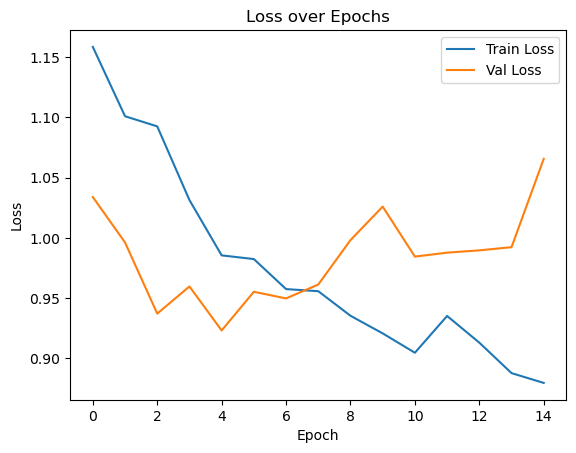

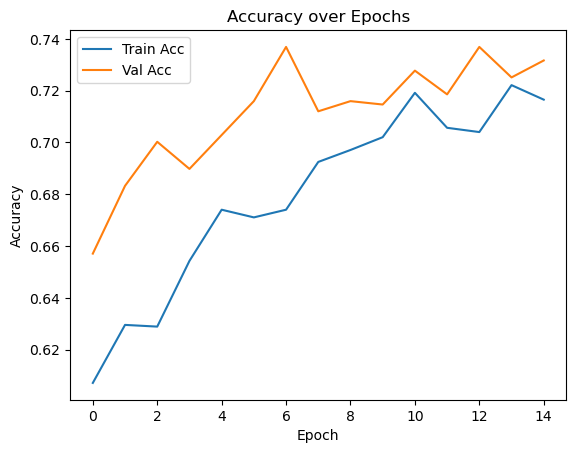

In [27]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## ResNet50

In [ ]:
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False 

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(L2_REG))(x)
x = Dropout(0.2)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

model_resnet50 = Model(inputs=base_model.input, outputs=output)
model_resnet50.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,122,761 (92.02 MB)

 Trainable params: 530,953 (2.03 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

In [33]:
model_resnet50.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('resnet50_best_model.h5', save_best_only=True)

history_resnet50 = model_resnet50.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.3686 - loss: 1.7644

607/607 ━━━━━━━━━━━━━━━━━━━━ 102s 164ms/step - accuracy: 0.3686 - loss: 1.7644 - val_accuracy: 0.4359 - val_loss: 1.7183
Epoch 2/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 94s 155ms/step - accuracy: 0.3770 - loss: 1.7487 - val_accuracy: 0.4097 - val_loss: 1.8032
Epoch 3/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.3828 - loss: 1.7739

607/607 ━━━━━━━━━━━━━━━━━━━━ 96s 158ms/step - accuracy: 0.3827 - loss: 1.7739 - val_accuracy: 0.4542 - val_loss: 1.7100
Epoch 4/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.3972 - loss: 1.7392

607/607 ━━━━━━━━━━━━━━━━━━━━ 100s 165ms/step - accuracy: 0.3972 - loss: 1.7392 - val_accuracy: 0.4267 - val_loss: 1.6533
Epoch 5/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 100s 165ms/step - accuracy: 0.3685 - loss: 1.7589 - val_accuracy: 0.4293 - val_loss: 1.7286
Epoch 6/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.3697 - loss: 1.7539

607/607 ━━━━━━━━━━━━━━━━━━━━ 101s 167ms/step - accuracy: 0.3697 - loss: 1.7539 - val_accuracy: 0.4228 - val_loss: 1.6501
Epoch 7/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 98s 162ms/step - accuracy: 0.3926 - loss: 1.7180 - val_accuracy: 0.4529 - val_loss: 1.6682
Epoch 8/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 100s 165ms/step - accuracy: 0.3992 - loss: 1.7053 - val_accuracy: 0.4241 - val_loss: 1.7403
Epoch 9/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 100s 165ms/step - accuracy: 0.3981 - loss: 1.7110 - val_accuracy: 0.4149 - val_loss: 1.7725
Epoch 10/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 95s 156ms/step - accuracy: 0.3656 - loss: 1.7590 - val_accuracy: 0.4149 - val_loss: 1.8534
Epoch 11/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 97s 160ms/step - accuracy: 0.4036 - loss: 1.7074 - val_accuracy: 0.4254 - val_loss: 1.7686
Epoch 12/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 98s 161ms/step - accuracy: 0.3958 - loss: 1.7169 - val_accuracy: 0.4634 - val_loss: 1.6867
Epoch 13/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.4097 - loss:

607/607 ━━━━━━━━━━━━━━━━━━━━ 96s 158ms/step - accuracy: 0.4096 - loss: 1.6490 - val_accuracy: 0.4503 - val_loss: 1.6348
Epoch 14/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 95s 157ms/step - accuracy: 0.4061 - loss: 1.7002 - val_accuracy: 0.4424 - val_loss: 1.7200
Epoch 15/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 89s 147ms/step - accuracy: 0.4043 - loss: 1.6705 - val_accuracy: 0.4306 - val_loss: 1.8342
Epoch 16/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.3993 - loss: 1.7101

607/607 ━━━━━━━━━━━━━━━━━━━━ 92s 151ms/step - accuracy: 0.3993 - loss: 1.7101 - val_accuracy: 0.4764 - val_loss: 1.5892
Epoch 17/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 99s 162ms/step - accuracy: 0.3982 - loss: 1.7103 - val_accuracy: 0.4516 - val_loss: 1.6591
Epoch 18/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 94s 155ms/step - accuracy: 0.4083 - loss: 1.6919 - val_accuracy: 0.4647 - val_loss: 1.7326
Epoch 19/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 93s 154ms/step - accuracy: 0.3839 - loss: 1.7349 - val_accuracy: 0.4568 - val_loss: 1.6492
Epoch 20/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 93s 154ms/step - accuracy: 0.4092 - loss: 1.6904 - val_accuracy: 0.4490 - val_loss: 1.6455
Epoch 21/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 96s 158ms/step - accuracy: 0.4200 - loss: 1.6541 - val_accuracy: 0.4346 - val_loss: 1.6921
Epoch 22/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 93s 153ms/step - accuracy: 0.3969 - loss: 1.6939 - val_accuracy: 0.4411 - val_loss: 1.6702
Epoch 23/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 94s 154ms/step - accuracy: 0.4213 - loss

In [ ]:
y_pred_probs_resnet50 = model_resnet50.predict(test_generator)
y_pred_resnet50 = np.argmax(y_pred_probs_resnet50, axis=1)
y_true = test_generator.classes  

class_labels = list(test_generator.class_indices.keys())


191/191 ━━━━━━━━━━━━━━━━━━━━ 26s 132ms/step


In [ ]:
print("Classification Report (ResNet50):")
print(classification_report(y_true, y_pred_resnet50, target_names=class_labels))

precision = precision_score(y_true, y_pred_resnet50, average='macro')
recall = recall_score(y_true, y_pred_resnet50, average='macro')
f1 = f1_score(y_true, y_pred_resnet50, average='macro')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

y_true_onehot = label_binarize(y_true, classes=np.arange(len(class_labels)))
auc = roc_auc_score(y_true_onehot, y_pred_probs_resnet50, average='macro', multi_class='ovr')
print(f"AUC (macro): {auc:.4f}")


Classification Report (ResNet50):
                       precision    recall  f1-score   support

          1-Cardboard       0.26      0.38      0.31        93
      2-Food Organics       0.58      0.51      0.54        83
              3-Glass       0.56      0.48      0.51        84
              4-Metal       0.50      0.67      0.57       158
5-Miscellaneous Trash       0.43      0.20      0.27        99
              6-Paper       0.45      0.44      0.45       100
            7-Plastic       0.49      0.42      0.45       185
      8-Textile Trash       0.33      0.11      0.16        64
         9-Vegetation       0.52      0.83      0.64        88

             accuracy                           0.47       954
            macro avg       0.46      0.45      0.43       954
         weighted avg       0.46      0.47      0.45       954

Precision: 0.4573
Recall: 0.4474
F1 Score: 0.4341
AUC (macro): 0.8315


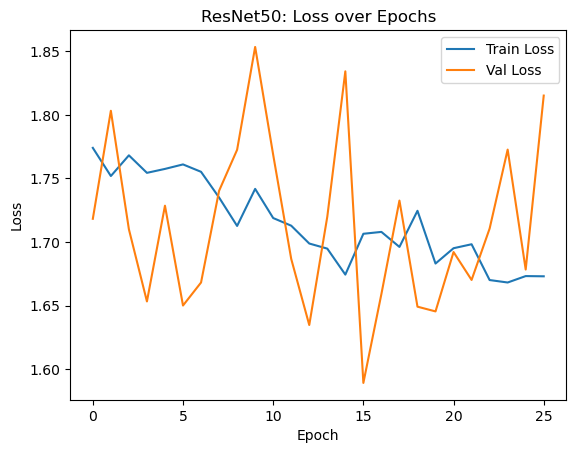

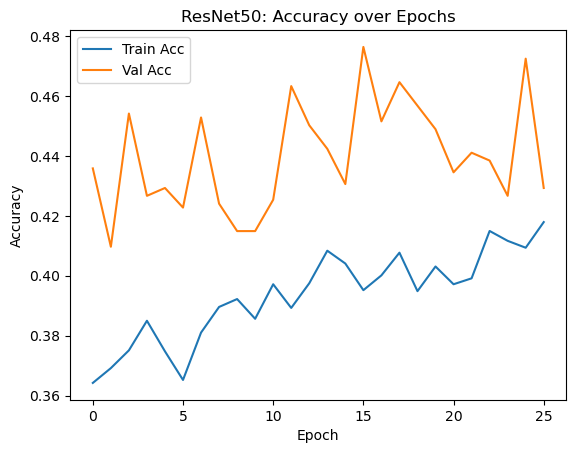

In [ ]:
plt.plot(history_resnet50.history['loss'], label='Train Loss')
plt.plot(history_resnet50.history['val_loss'], label='Val Loss')
plt.title('ResNet50: Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history_resnet50.history['accuracy'], label='Train Acc')
plt.plot(history_resnet50.history['val_accuracy'], label='Val Acc')
plt.title('ResNet50: Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## ResNet101

In [ ]:
base_model = ResNet101(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False 

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(L2_REG))(x)
x = Dropout(0.2)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

model_resnet101 = Model(inputs=base_model.input, outputs=output)
model_resnet101.summary()

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 43,193,225 (164.77 MB)

 Trainable params: 530,953 (2.03 MB)

 Non-trainable params: 42,662,272 (162.74 MB)

In [38]:
model_resnet101.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('resnet101_best_model.h5', save_best_only=True)

history_resnet101 = model_resnet101.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.2387 - loss: 2.1616

607/607 ━━━━━━━━━━━━━━━━━━━━ 172s 277ms/step - accuracy: 0.2388 - loss: 2.1615 - val_accuracy: 0.3586 - val_loss: 1.7826
Epoch 2/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 166s 274ms/step - accuracy: 0.2839 - loss: 1.9468 - val_accuracy: 0.3560 - val_loss: 1.8194
Epoch 3/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 165s 272ms/step - accuracy: 0.3203 - loss: 1.8841 - val_accuracy: 0.3717 - val_loss: 1.9935
Epoch 4/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.3369 - loss: 1.8512

607/607 ━━━━━━━━━━━━━━━━━━━━ 1138s 2s/step - accuracy: 0.3369 - loss: 1.8511 - val_accuracy: 0.4162 - val_loss: 1.7289
Epoch 5/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 890s 1s/step - accuracy: 0.3566 - loss: 1.8247 - val_accuracy: 0.3848 - val_loss: 1.7349
Epoch 6/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 354s 584ms/step - accuracy: 0.3309 - loss: 1.8560 - val_accuracy: 0.4031 - val_loss: 1.7671
Epoch 7/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 176s 289ms/step - accuracy: 0.3271 - loss: 1.8679 - val_accuracy: 0.4018 - val_loss: 1.7469
Epoch 8/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.3476 - loss: 1.7849

607/607 ━━━━━━━━━━━━━━━━━━━━ 174s 287ms/step - accuracy: 0.3476 - loss: 1.7850 - val_accuracy: 0.4149 - val_loss: 1.7138
Epoch 9/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.3539 - loss: 1.8188

607/607 ━━━━━━━━━━━━━━━━━━━━ 175s 289ms/step - accuracy: 0.3539 - loss: 1.8188 - val_accuracy: 0.4607 - val_loss: 1.6581
Epoch 10/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 179s 294ms/step - accuracy: 0.3593 - loss: 1.7968 - val_accuracy: 0.4202 - val_loss: 1.7253
Epoch 11/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 181s 299ms/step - accuracy: 0.3545 - loss: 1.7922 - val_accuracy: 0.4045 - val_loss: 1.7618
Epoch 12/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 175s 288ms/step - accuracy: 0.3445 - loss: 1.7987 - val_accuracy: 0.4110 - val_loss: 1.8149
Epoch 13/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 175s 288ms/step - accuracy: 0.3712 - loss: 1.7823 - val_accuracy: 0.4110 - val_loss: 1.6674
Epoch 14/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 175s 289ms/step - accuracy: 0.3499 - loss: 1.8059 - val_accuracy: 0.4188 - val_loss: 1.7906
Epoch 15/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.3562 - loss: 1.7865

607/607 ━━━━━━━━━━━━━━━━━━━━ 167s 276ms/step - accuracy: 0.3562 - loss: 1.7865 - val_accuracy: 0.4699 - val_loss: 1.5810
Epoch 16/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 171s 281ms/step - accuracy: 0.3694 - loss: 1.7891 - val_accuracy: 0.3901 - val_loss: 1.7375
Epoch 17/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 168s 277ms/step - accuracy: 0.3714 - loss: 1.7813 - val_accuracy: 0.4686 - val_loss: 1.6163
Epoch 18/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 239s 395ms/step - accuracy: 0.3616 - loss: 1.7823 - val_accuracy: 0.4542 - val_loss: 1.5906
Epoch 19/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 843s 1s/step - accuracy: 0.3786 - loss: 1.7736 - val_accuracy: 0.4031 - val_loss: 1.6780
Epoch 20/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 1068s 2s/step - accuracy: 0.3809 - loss: 1.7572 - val_accuracy: 0.4319 - val_loss: 1.6792
Epoch 21/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 228s 376ms/step - accuracy: 0.3728 - loss: 1.7722 - val_accuracy: 0.4149 - val_loss: 1.7392
Epoch 22/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 336s 553ms/step - accuracy: 0.3735 - l

In [ ]:
y_pred_probs_resnet101 = model_resnet101.predict(test_generator)
y_pred_resnet101 = np.argmax(y_pred_probs_resnet101, axis=1)
y_true = test_generator.classes

class_labels = list(test_generator.class_indices.keys())

191/191 ━━━━━━━━━━━━━━━━━━━━ 44s 226ms/step


In [ ]:
print("Classification Report (ResNet101):")
print(classification_report(y_true, y_pred_resnet101, target_names=class_labels))

precision = precision_score(y_true, y_pred_resnet101, average='macro')
recall = recall_score(y_true, y_pred_resnet101, average='macro')
f1 = f1_score(y_true, y_pred_resnet101, average='macro')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

y_true_onehot = label_binarize(y_true, classes=np.arange(len(class_labels)))
auc = roc_auc_score(y_true_onehot, y_pred_probs_resnet101, average='macro', multi_class='ovr')
print(f"AUC (macro): {auc:.4f}")


Classification Report (ResNet101):
                       precision    recall  f1-score   support

          1-Cardboard       0.44      0.28      0.34        93
      2-Food Organics       0.45      0.42      0.44        83
              3-Glass       0.69      0.35      0.46        84
              4-Metal       0.42      0.78      0.55       158
5-Miscellaneous Trash       0.34      0.13      0.19        99
              6-Paper       0.47      0.37      0.41       100
            7-Plastic       0.43      0.51      0.47       185
      8-Textile Trash       1.00      0.03      0.06        64
         9-Vegetation       0.58      0.91      0.70        88

             accuracy                           0.46       954
            macro avg       0.54      0.42      0.40       954
         weighted avg       0.50      0.46      0.43       954

Precision: 0.5354
Recall: 0.4207
F1 Score: 0.4024
AUC (macro): 0.8194


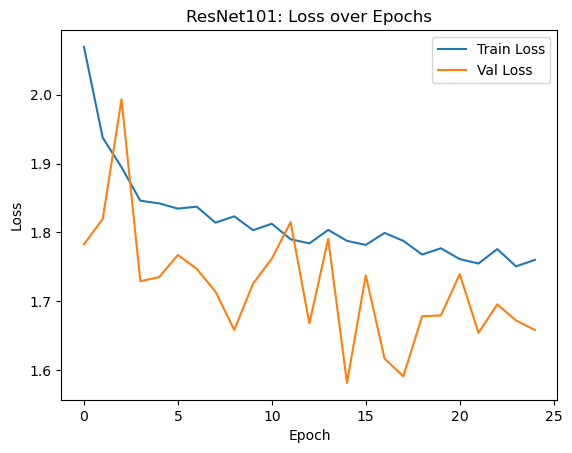

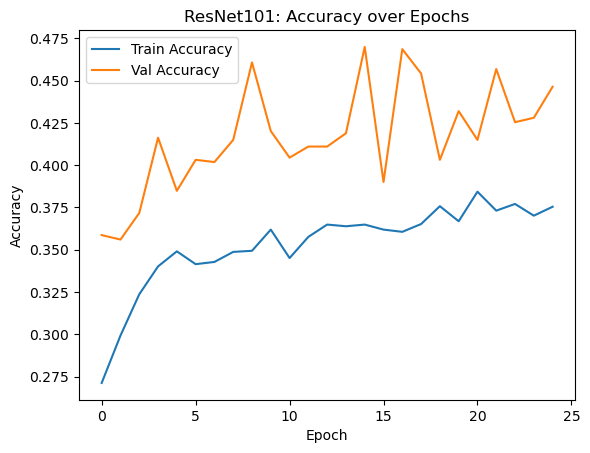

In [ ]:
plt.plot(history_resnet101.history['loss'], label='Train Loss')
plt.plot(history_resnet101.history['val_loss'], label='Val Loss')
plt.title('ResNet101: Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history_resnet101.history['accuracy'], label='Train Accuracy')
plt.plot(history_resnet101.history['val_accuracy'], label='Val Accuracy')
plt.title('ResNet101: Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## EfficientNetB0

In [43]:
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False 

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(L2_REG))(x)
x = Dropout(0.2)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

model_effnet = Model(inputs=base_model.input, outputs=output)
model_effnet.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_4[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,384,940 (16.73 MB)

 Trainable params: 332,809 (1.27 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [44]:
model_effnet.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('efficientnetb0_best_model.h5', save_best_only=True)

history_effnet = model_effnet.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.1442 - loss: 2.9803

607/607 ━━━━━━━━━━━━━━━━━━━━ 47s 73ms/step - accuracy: 0.1442 - loss: 2.9801 - val_accuracy: 0.1139 - val_loss: 2.2310
Epoch 2/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.1311 - loss: 2.4848

607/607 ━━━━━━━━━━━━━━━━━━━━ 42s 69ms/step - accuracy: 0.1311 - loss: 2.4846 - val_accuracy: 0.1937 - val_loss: 2.2119
Epoch 3/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.1825 - loss: 2.2513

607/607 ━━━━━━━━━━━━━━━━━━━━ 42s 69ms/step - accuracy: 0.1825 - loss: 2.2513 - val_accuracy: 0.1937 - val_loss: 2.1969
Epoch 4/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.1839 - loss: 2.1900

607/607 ━━━━━━━━━━━━━━━━━━━━ 43s 72ms/step - accuracy: 0.1839 - loss: 2.1900 - val_accuracy: 0.1937 - val_loss: 2.1890
Epoch 5/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.1851 - loss: 2.2081

607/607 ━━━━━━━━━━━━━━━━━━━━ 44s 72ms/step - accuracy: 0.1851 - loss: 2.2081 - val_accuracy: 0.1937 - val_loss: 2.1780
Epoch 6/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.1960 - loss: 2.1885

607/607 ━━━━━━━━━━━━━━━━━━━━ 43s 70ms/step - accuracy: 0.1960 - loss: 2.1885 - val_accuracy: 0.1937 - val_loss: 2.1588
Epoch 7/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.1791 - loss: 2.1835

607/607 ━━━━━━━━━━━━━━━━━━━━ 44s 72ms/step - accuracy: 0.1792 - loss: 2.1834 - val_accuracy: 0.1937 - val_loss: 2.1443
Epoch 8/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.2008 - loss: 2.1748

607/607 ━━━━━━━━━━━━━━━━━━━━ 43s 71ms/step - accuracy: 0.2007 - loss: 2.1748 - val_accuracy: 0.2147 - val_loss: 2.1343
Epoch 9/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 43s 71ms/step - accuracy: 0.1853 - loss: 2.1629 - val_accuracy: 0.1937 - val_loss: 2.1370
Epoch 10/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.1939 - loss: 2.1702

607/607 ━━━━━━━━━━━━━━━━━━━━ 43s 71ms/step - accuracy: 0.1939 - loss: 2.1702 - val_accuracy: 0.1937 - val_loss: 2.1151
Epoch 11/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.2007 - loss: 2.1504

607/607 ━━━━━━━━━━━━━━━━━━━━ 44s 73ms/step - accuracy: 0.2007 - loss: 2.1504 - val_accuracy: 0.2291 - val_loss: 2.0938
Epoch 12/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.1918 - loss: 2.1555

607/607 ━━━━━━━━━━━━━━━━━━━━ 44s 72ms/step - accuracy: 0.1918 - loss: 2.1555 - val_accuracy: 0.2212 - val_loss: 2.0873
Epoch 13/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.1882 - loss: 2.1607

607/607 ━━━━━━━━━━━━━━━━━━━━ 43s 70ms/step - accuracy: 0.1882 - loss: 2.1607 - val_accuracy: 0.2264 - val_loss: 2.0824
Epoch 14/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.2050 - loss: 2.1387

607/607 ━━━━━━━━━━━━━━━━━━━━ 44s 72ms/step - accuracy: 0.2050 - loss: 2.1387 - val_accuracy: 0.2199 - val_loss: 2.0774
Epoch 15/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.2034 - loss: 2.1298

607/607 ━━━━━━━━━━━━━━━━━━━━ 43s 70ms/step - accuracy: 0.2034 - loss: 2.1298 - val_accuracy: 0.2277 - val_loss: 2.0601
Epoch 16/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 42s 70ms/step - accuracy: 0.2249 - loss: 2.1164 - val_accuracy: 0.2199 - val_loss: 2.0784
Epoch 17/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 45s 75ms/step - accuracy: 0.1833 - loss: 2.1255 - val_accuracy: 0.2212 - val_loss: 2.0716
Epoch 18/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.2160 - loss: 2.1193

607/607 ━━━━━━━━━━━━━━━━━━━━ 43s 72ms/step - accuracy: 0.2160 - loss: 2.1193 - val_accuracy: 0.2264 - val_loss: 2.0587
Epoch 19/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.2243 - loss: 2.1048

607/607 ━━━━━━━━━━━━━━━━━━━━ 43s 71ms/step - accuracy: 0.2243 - loss: 2.1048 - val_accuracy: 0.2343 - val_loss: 2.0547
Epoch 20/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 43s 71ms/step - accuracy: 0.2096 - loss: 2.1190 - val_accuracy: 0.2251 - val_loss: 2.0593
Epoch 21/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.2212 - loss: 2.0926

607/607 ━━━━━━━━━━━━━━━━━━━━ 43s 70ms/step - accuracy: 0.2212 - loss: 2.0926 - val_accuracy: 0.2330 - val_loss: 2.0312
Epoch 22/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 43s 71ms/step - accuracy: 0.2053 - loss: 2.1204 - val_accuracy: 0.2173 - val_loss: 2.0803
Epoch 23/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 43s 71ms/step - accuracy: 0.2357 - loss: 2.0814 - val_accuracy: 0.2343 - val_loss: 2.0477
Epoch 24/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.2293 - loss: 2.0914

607/607 ━━━━━━━━━━━━━━━━━━━━ 43s 71ms/step - accuracy: 0.2292 - loss: 2.0914 - val_accuracy: 0.2343 - val_loss: 2.0256
Epoch 25/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 42s 70ms/step - accuracy: 0.2118 - loss: 2.1026 - val_accuracy: 0.2343 - val_loss: 2.0284
Epoch 26/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 43s 71ms/step - accuracy: 0.2205 - loss: 2.0849 - val_accuracy: 0.2343 - val_loss: 2.0370
Epoch 27/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 42s 69ms/step - accuracy: 0.2107 - loss: 2.0976 - val_accuracy: 0.2304 - val_loss: 2.0483
Epoch 28/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.2222 - loss: 2.0911

607/607 ━━━━━━━━━━━━━━━━━━━━ 43s 70ms/step - accuracy: 0.2222 - loss: 2.0911 - val_accuracy: 0.2343 - val_loss: 2.0245
Epoch 29/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 42s 69ms/step - accuracy: 0.2066 - loss: 2.1085 - val_accuracy: 0.2330 - val_loss: 2.0295
Epoch 30/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 42s 69ms/step - accuracy: 0.2258 - loss: 2.0793 - val_accuracy: 0.2291 - val_loss: 2.0463
Epoch 31/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 41s 68ms/step - accuracy: 0.2224 - loss: 2.0832 - val_accuracy: 0.2291 - val_loss: 2.0551
Epoch 32/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 41s 68ms/step - accuracy: 0.2366 - loss: 2.0628 - val_accuracy: 0.2330 - val_loss: 2.0342
Epoch 33/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 42s 69ms/step - accuracy: 0.2244 - loss: 2.0778 - val_accuracy: 0.2330 - val_loss: 2.0365
Epoch 34/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 43s 70ms/step - accuracy: 0.2200 - loss: 2.0980 - val_accuracy: 0.2291 - val_loss: 2.0513
Epoch 35/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 82s 136ms/step - accuracy: 0.2157 - loss: 2.088

607/607 ━━━━━━━━━━━━━━━━━━━━ 486s 802ms/step - accuracy: 0.2279 - loss: 2.0724 - val_accuracy: 0.2343 - val_loss: 2.0124
Epoch 37/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 42s 69ms/step - accuracy: 0.2226 - loss: 2.0935 - val_accuracy: 0.2330 - val_loss: 2.0209
Epoch 38/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 715s 1s/step - accuracy: 0.2217 - loss: 2.0652 - val_accuracy: 0.2304 - val_loss: 2.0449
Epoch 39/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 210s 347ms/step - accuracy: 0.2136 - loss: 2.0906 - val_accuracy: 0.2304 - val_loss: 2.0482
Epoch 40/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 42s 69ms/step - accuracy: 0.2206 - loss: 2.0734 - val_accuracy: 0.2291 - val_loss: 2.0583
Epoch 41/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 42s 69ms/step - accuracy: 0.2226 - loss: 2.0650 - val_accuracy: 0.2343 - val_loss: 2.0250
Epoch 42/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 42s 69ms/step - accuracy: 0.2294 - loss: 2.0894 - val_accuracy: 0.2356 - val_loss: 2.0214
Epoch 43/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 44s 72ms/step - accuracy: 0.2048 - loss: 2.0

607/607 ━━━━━━━━━━━━━━━━━━━━ 45s 74ms/step - accuracy: 0.2170 - loss: 2.0855 - val_accuracy: 0.2382 - val_loss: 1.9922
Epoch 46/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 45s 74ms/step - accuracy: 0.2056 - loss: 2.0887 - val_accuracy: 0.2291 - val_loss: 2.0448
Epoch 47/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 46s 76ms/step - accuracy: 0.2079 - loss: 2.0986 - val_accuracy: 0.2251 - val_loss: 2.0664
Epoch 48/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.2345 - loss: 2.0593 - val_accuracy: 0.2291 - val_loss: 2.0373
Epoch 49/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 71s 118ms/step - accuracy: 0.2171 - loss: 2.0777 - val_accuracy: 0.2343 - val_loss: 2.0220
Epoch 50/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 569s 939ms/step - accuracy: 0.2309 - loss: 2.0665 - val_accuracy: 0.2251 - val_loss: 2.0757
Epoch 51/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 1072s 2s/step - accuracy: 0.2005 - loss: 2.0828 - val_accuracy: 0.2291 - val_loss: 2.0656
Epoch 52/100
607/607 ━━━━━━━━━━━━━━━━━━━━ 42s 70ms/step - accuracy: 0.2079 - loss: 2.

In [45]:
y_pred_probs_effnet = model_effnet.predict(test_generator)
y_pred_effnet = np.argmax(y_pred_probs_effnet, axis=1)
y_true = test_generator.classes

class_labels = list(test_generator.class_indices.keys())


191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 57ms/step


In [46]:
print("Classification Report (EfficientNetB0):")
print(classification_report(y_true, y_pred_effnet, target_names=class_labels))

precision = precision_score(y_true, y_pred_effnet, average='macro')
recall = recall_score(y_true, y_pred_effnet, average='macro')
f1 = f1_score(y_true, y_pred_effnet, average='macro')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

y_true_onehot = label_binarize(y_true, classes=np.arange(len(class_labels)))
auc = roc_auc_score(y_true_onehot, y_pred_probs_effnet, average='macro', multi_class='ovr')
print(f"AUC (macro): {auc:.4f}")


Classification Report (EfficientNetB0):
                       precision    recall  f1-score   support

          1-Cardboard       0.00      0.00      0.00        93
      2-Food Organics       0.00      0.00      0.00        83
              3-Glass       0.00      0.00      0.00        84
              4-Metal       0.00      0.00      0.00       158
5-Miscellaneous Trash       0.00      0.00      0.00        99
              6-Paper       0.00      0.00      0.00       100
            7-Plastic       0.22      0.96      0.35       185
      8-Textile Trash       0.00      0.00      0.00        64
         9-Vegetation       0.52      0.78      0.62        88

             accuracy                           0.26       954
            macro avg       0.08      0.19      0.11       954
         weighted avg       0.09      0.26      0.13       954

Precision: 0.0817
Recall: 0.1940
F1 Score: 0.1087
AUC (macro): 0.6643


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-pa

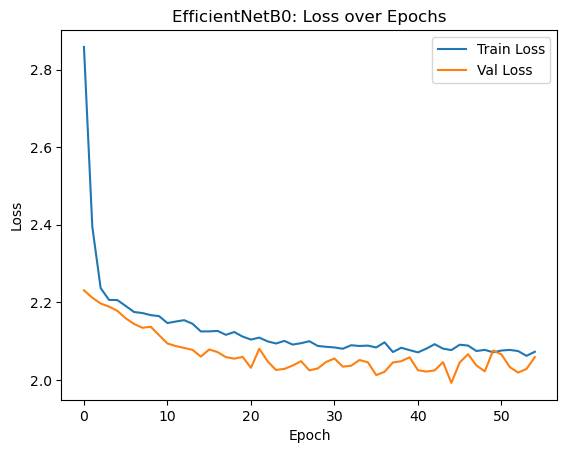

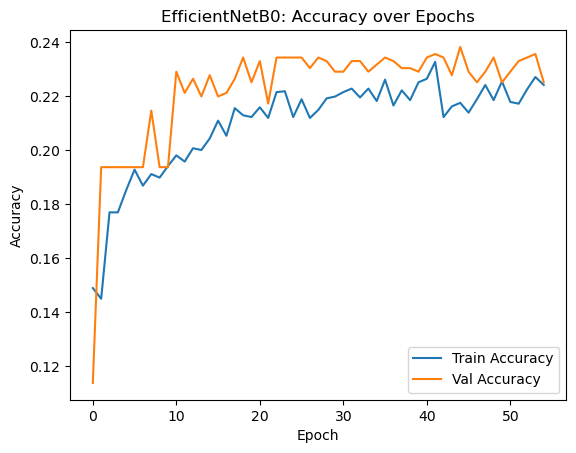

In [47]:
plt.plot(history_effnet.history['loss'], label='Train Loss')
plt.plot(history_effnet.history['val_loss'], label='Val Loss')
plt.title('EfficientNetB0: Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history_effnet.history['accuracy'], label='Train Accuracy')
plt.plot(history_effnet.history['val_accuracy'], label='Val Accuracy')
plt.title('EfficientNetB0: Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## Analysis

In [ ]:
summary_data = {
    "Model": ["VGG16", "ResNet50", "ResNet101", "EfficientNetB0"],
    "Precision": [0.7167, 0.4573, 0.5354, 0.0817],
    "Recall":    [0.7054, 0.4474, 0.4207, 0.1940],
    "F1 Score":  [0.7065, 0.4341, 0.4024, 0.1087],
    "AUC":       [0.9541, 0.8315, 0.8194, 0.6643]
}

df = pd.DataFrame(summary_data)
print(df)


            Model  Precision  Recall  F1 Score     AUC
0           VGG16     0.7167  0.7054    0.7065  0.9541
1        ResNet50     0.4573  0.4474    0.4341  0.8315
2       ResNet101     0.5354  0.4207    0.4024  0.8194
3  EfficientNetB0     0.0817  0.1940    0.1087  0.6643


The model that clearly outperforms the rest of the models is the VGG16 model as the precision, recall, F1, and AUC scores are the highest